In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from statsmodels.graphics.tsaplots import plot_acf

print(os.getcwd())

### Import data

In [ ]:
dataDir = "../data"
df = pd.read_csv("/content/ts_0011_sid6322070.csv")
                 #Weekend trends #ts_0109_sid6322115.csv")
                 #weekday trend #ts_0118_sid6322122.csv")
                 
                 #ts_0007_sid6321576.csv")
                 
                 #ts_0111_sid6322117.csv")


In [ ]:
df2 = df.drop(columns = ["Unnamed: 0", "sid", "uprns", "sensType"])
df2['datetime'] = pd.to_datetime(df['datetime'])
df2.head()

In [ ]:
# Add day and month name
df2['dayname'] = df2['datetime'].apply(lambda x: x.dayofweek)
df2['month'] = df2['datetime'].apply(lambda x: x.month)
df2['dayofyear'] = df2['datetime'].apply(lambda x: x.dayofyear)


In [ ]:
df.isnull().values.any()

In [ ]:
# Calulate overall mean
y_mean = df2['PM2_5'].mean()
df2['y_norm'] = df2['PM2_5']-y_mean


In [ ]:
# Plot weekday trend
days_dict = {
    0: "Monday",
    1: "Tuesday",
    2: "Wednesday",
    3: "Thursday",
    4: "Friday",
    5: "Saturday",
    6: "Sunday"
            }
df_day = df2.groupby("dayname", as_index = False).mean()
df_day = df_day.sort_values(by = ['dayname'], axis = 0, ascending = True)
df_day['dayname2'] = df_day['dayname'].apply(lambda x: days_dict[x])
plt.plot(df_day['dayname2'],df_day['y_norm'], color = 'dodgerblue')
plt.tick_params(axis='x', labelrotation = -45)

In [ ]:
month_dict = {
    1:"January",
    2:"February",
    3:"March",
    4:"April",
    5:"May",
    6:"June",
    7:"July",
    8:"August",
    9:"September",
    10:"October",
    11:"November",
    12:"December"
}

#Plot monthly trend
df_month = df2.groupby("month", as_index = False).mean()
df_month = df_month.sort_values(['month'],axis = 0, ascending = True)
df_month['month2'] = df_month['month'].apply(lambda x: month_dict[x])
plt.plot(df_month['month2'],df_month['y_norm'])


In [ ]:
#Plot monthly trend
df3 = df2.groupby("dayofyear").mean()
df3 = df3.sort_index(axis = 0, ascending = True)
plt.scatter(df3.index,df3['y_norm'])
import seaborn as sns
sns.relplot(
    data=df3, x="dayofyear", y="y_norm", kind="line"
)

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
df_trends = df2[['datetime', 'PM2_5']].set_index('datetime')
res = seasonal_decompose(df_trends, model = "additive",periods = 36000)

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
res.trend.plot(ax=ax1,ylabel = "trend")
res.resid.plot(ax=ax2,ylabel = "seasoanlity")
res.seasonal.plot(ax=ax3,ylabel = "residual")
plt.show()

## Auto correlation and Partial correlation plots

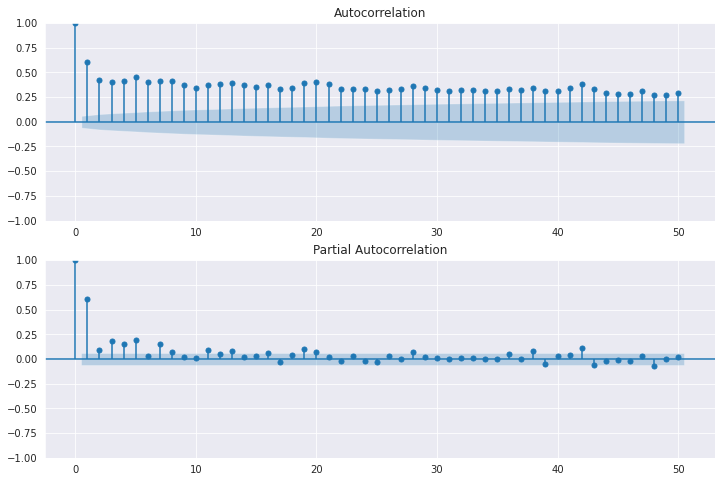

In [37]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df2['y'], lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df2['y'], lags=50, ax=ax2)
plt.show()

In [42]:
df_resampled = df_trends.resample('H').mean()
df_resampled = df_resampled.fillna(0)

NameError: name 'df_trends' is not defined

NameError: name 'df_resampled' is not defined

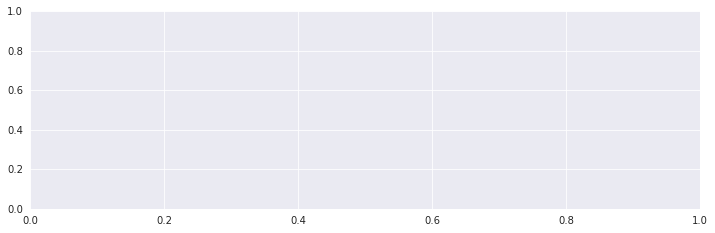

In [43]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_resampled['PM2_5'], lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_resampled['PM2_5'], lags=50, ax=ax2)
plt.show()

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
res = seasonal_decompose(df_resampled, model = "additive",period = 360)

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
res.trend.plot(ax=ax1,ylabel = "trend")
res.resid.plot(ax=ax2,ylabel = "seasoanlity")
res.seasonal.plot(ax=ax3,ylabel = "residual")
plt.show()#

In [ ]:
import altair as alt

df_alt = df_resampled.reset_index()
df_alt = df_alt.rename(columns = {'datetime':'ds',
                                 'PM2_5':'y'})
alt.data_transformers.enable('default', max_rows=None)
alt.Chart(df_alt).mark_line().encode(
    alt.X('ds:T'),
    alt.Y('y:Q',
         scale = alt.Scale(domain = (-50, 300)))
)

## Import weather data

In [ ]:
weather_2018 = pd.read_csv("../data/rawData/2018_hourly_weather.csv")
weather_2019 = pd.read_csv("../data/rawData/2019_hourly_weather.csv")
weather_2020 = pd.read_csv("../data/rawData/2020_hourly_weather.csv")

In [ ]:
df_weather = weather_2018.append(weather_2019, ignore_index = True)

In [ ]:
df_weather = df_weather.append(weather_2020, ignore_index = True)

In [ ]:
df_weather['ds'] = pd.to_datetime(df_weather['ds'])

### Join weather data to air quality data

In [ ]:
df_joined = df_alt.merge(df_weather, how = 'inner', on = 'ds')

In [ ]:
df_joined = df_joined[~df_joined['air_temperature'].isnull()]

In [48]:
df_joined = pd.read_csv("../data/cleanData/df_analysis.csv")

## Plotting Air Temp and PM2_5

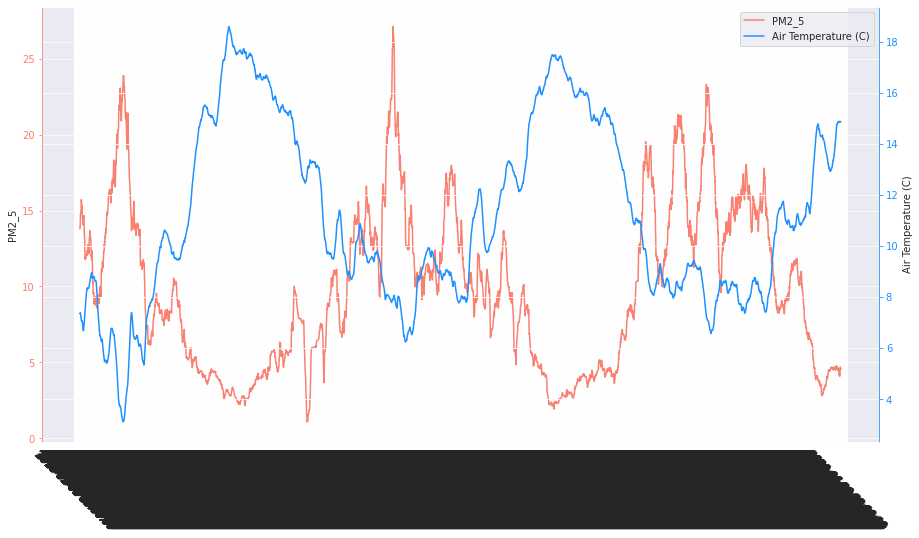

In [50]:
from statsmodels.tsa.seasonal import seasonal_decompose
df_joined = df_joined.dropna()
res_pm2_5 = seasonal_decompose(df_joined[['ds','y']].set_index('ds'), model = "additive",period = 360)
res_air_temp = seasonal_decompose(df_joined[['ds','air_temperature']].set_index('ds'), model = "additive",period = 360)

fig, ax = plt.subplots(figsize = (15, 8))

line1, = ax.plot(res_pm2_5.trend,label = "PM2_5", color = 'salmon')
ax.set_ylabel("PM2_5")
ax.tick_params(axis='y', colors='salmon')

ax2 = ax.twinx()

line2, = ax2.plot(res_air_temp.trend, label = "Air Temperature (C)", color = 'dodgerblue')
ax2.set_ylabel("Air Temperature (C)")
ax2.tick_params(axis='y', colors='dodgerblue')
ax2.spines['right'].set_color('dodgerblue')
ax2.spines['left'].set_color('salmon')
plt.legend(handles = [line1, line2])
ax.tick_params(axis='x', labelrotation = -45)
plt.rc('font', size = 15)

plt.show()

fig.savefig("plot.svg", dpi = 500)

## Testing for stationarity

In [ ]:
from statsmodels.tsa.stattools import adfuller
adfuller_test = adfuller(df_joined['y'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

In [ ]:
from statsmodels.tsa.stattools import adfuller
adfuller_test = adfuller(df_joined['air_temperature'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

p values suggest both variables are satationary so do not need to difference

## Getting best VAR model
https://towardsdatascience.com/multivariate-time-series-forecasting-456ace675971

In [44]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

df_var = df_joined.copy()
df_var.index = pd.DatetimeIndex(df_var.ds).to_period('H')
df_var = df_var.drop('ds', axis = 1)

NameError: name 'df_joined' is not defined

In [ ]:
size = int(len(df_joined) * 0.8)
train = df_var[['y', 'air_temperature']].iloc[:size, :]
test = df_var[['y', 'air_temperature']].iloc[size:, :]           

In [ ]:
forecasting_model = VAR(train)

results_aic = []
for p in range(1, 10):
    results = forecasting_model.fit(p)
    results_aic.append(results.aic)

In [ ]:
import seaborn as sns
sns.set()
plt.plot(list(np.arange(1,500,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

In [ ]:
results_aic.index(min(results_aic))

In [ ]:
results = forecasting_model.fit(171)
results.summary()

In [ ]:
lagged_values = train.values[-171:]

forecast = pd.DataFrame(results.forecast(y = lagged_values, steps = 4378),
                       index = test.index, columns = ['y', 'air_temp'])

In [ ]:
forecast

## Time series forecasting
https://medium.com/analytics-vidhya/time-series-forecasting-a-complete-guide-d963142da33f

### Import libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math
from scipy.stats import variation

df_joined = pd.read_csv("/content/df_analysis.csv")

In [ ]:
%matplotlib inline
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

In [ ]:
import sklearn
from sklearn.metrics import mean_squared_error

In [ ]:
df = df_joined
df.shape

In [ ]:
df.info()

In [ ]:
df_pm25 = df[['ds', 'y']].set_index('ds').asfreq('H')

plt.figure(figsize=(18,7))
plt.plot(df_pm25, label='PM2_5', color = 'dodgerblue')
plt.legend(loc='best')
plt.xticks(rotation = 90,fontweight="bold")
plt.show()

In [ ]:
from pylab import rcParams
import statsmodels.api as sm

df_sd = df[['ds', 'y']].copy()
df_sd['ds'] = pd.to_datetime(df_sd['ds'])
df_sd = df_sd.set_index('ds')
df_sd = df_sd.resample('H').mean()
df_sd = df_sd.fillna(0)

In [ ]:
rcParams['figure.figsize'] = 12, 8
decomposition = sm.tsa.seasonal_decompose(df_sd, model='additive', period = 3600) # additive seasonal index
fig = decomposition.plot()
plt.show()

## Building and avaluating time series models

In [53]:
train_len = int(len(df_sd)*0.8)
train = df_sd[0 : train_len]
test = df_sd[train_len : ]

### Simple time series methods

#### Naive method

In [54]:
y_hat_naive = test.copy()
y_hat_naive['naive_forecast'] = train['y'][train_len-1]

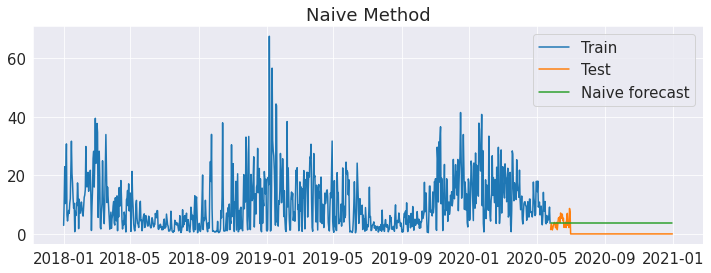

In [55]:
# Plot train, test and forecast

plt.figure(figsize=(12,4))
plt.plot(train['y'], label='Train')
plt.plot(test['y'], label='Test')
plt.plot(y_hat_naive['naive_forecast'], label='Naive forecast')
plt.legend(loc='best')
plt.title('Naive Method')
plt.show()

In [56]:
# Calculate RMSE and MAPE

from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['y'], y_hat_naive['naive_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['y']-y_hat_naive['naive_forecast'])/test['y'])*100,2)

results = pd.DataFrame({'Method':['Naive method'], 'MAPE': [mape], 'RMSE': [rmse]})
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,3.4,inf


#### Simple average method

In [ ]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['y'].mean()

In [ ]:
# Plot train, test and forecast

plt.figure(figsize=(12,4))
plt.plot(train['y'], label='Train')
plt.plot(test['y'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Simple average forecast')
plt.legend(loc='best')
plt.title('Simple Average Method')
plt.show()

In [ ]:
# Calculate RMSE and MAPE

rmse = np.sqrt(mean_squared_error(test['y'], y_hat_avg['avg_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['y']-y_hat_avg['avg_forecast'])/test['y'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple average method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

#### Simple moving average method

In [ ]:
y_hat_sma = df_sd.copy()
ma_window = 12
y_hat_sma['sma_forecast'] = df_sd['y'].rolling(ma_window).mean()
y_hat_sma['sma_forecast'][train_len:] = y_hat_sma['sma_forecast'][train_len-1]

In [ ]:
# Plot train, test and forecast

plt.figure(figsize=(12,4))
plt.plot(train['y'], label='Train')
plt.plot(test['y'], label='Test')
plt.plot(y_hat_sma['sma_forecast'], label='Simple moving average forecast')
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()

In [ ]:
# Calculate RMSE and MAPE

rmse = np.sqrt(mean_squared_error(test['y'], y_hat_sma['sma_forecast'][train_len:])).round(2)
mape = np.round(np.mean(np.abs(test['y']-y_hat_sma['sma_forecast'][train_len:])/test['y'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple moving average forecast'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

### Exponential Smoothing Techniques

#### Simple exponential smoothing

In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
model = SimpleExpSmoothing(train['y'])
model_fit = model.fit(optimized=True)
model_fit.params
y_hat_ses = test.copy()
y_hat_ses['ses_forecast'] = model_fit.forecast(len(test))

In [ ]:
# Plot train, test, forecast

plt.figure(figsize=(12,4))
plt.plot(train['y'], label='Train')
plt.plot(test['y'], label='Test')
plt.plot(y_hat_ses['ses_forecast'], label='Simple exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Simple Exponential Smoothing Method')
plt.show()

In [ ]:
# Calculate RMSE and MAPE

rmse = np.sqrt(mean_squared_error(test['y'], y_hat_ses['ses_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['y']-y_hat_ses['ses_forecast'])/test['y'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple exponential smoothing forecast'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

#### Holt's method with trend

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(np.asarray(train['y']) ,seasonal_periods=12 ,trend='additive', seasonal=None)
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_holt = test.copy()
y_hat_holt['holt_forecast'] = model_fit.forecast(len(test))

In [ ]:
# Plot train, test, forecast

plt.figure(figsize=(12,4))
plt.plot( train['y'], label='Train')
plt.plot(test['y'], label='Test')
plt.plot(y_hat_holt['holt_forecast'], label='Holt\'s exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Holt\'s Exponential Smoothing Method')
plt.show()

In [ ]:
# Calculate RMSE and MAPE

rmse = np.sqrt(mean_squared_error(test['y'], y_hat_holt['holt_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['y']-y_hat_holt['holt_forecast'])/test['y'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt\'s exponential smoothing method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

#### Holt Winters' additive method with trend and seasonality

In [ ]:
y_hat_hwa = test.copy()
model = ExponentialSmoothing(np.asarray(train['y']) ,seasonal_periods=12 ,trend='add', seasonal='add')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwa['hw_forecast'] = model_fit.forecast(len(test))

In [ ]:
# Plot train, test, forecast

plt.figure(figsize=(12,4))
plt.plot( train['y'], label='Train')
plt.plot(test['y'], label='Test')
plt.plot(y_hat_hwa['hw_forecast'], label='Holt Winters\'s additive forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Additive Method')
plt.show()

In [ ]:
# Calculate RMSE and MAPE

rmse = np.sqrt(mean_squared_error(test['y'], y_hat_hwa['hw_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['y']-y_hat_hwa['hw_forecast'])/test['y'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt Winters\' additive method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

### Auto regressive methods

In [ ]:
# Check for sationarity using Augmented Dickey-Fuller (ADF) test

from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df_sd['y'])

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' %adf_test[1])

Inference : p-value is less than 0.05. This means that the series is stationary.

In [ ]:
# Check for sationarity using Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test

from statsmodels.tsa.stattools import kpss
kpss_test = kpss(df_sd['y'])

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])


Inference : p-value is greater than 0.05. This means that the series is not stationary.

### Auto regression method (AR)

In [ ]:
train_len = int(len(df_sd)-10)
train = df_sd[0 : train_len]
test = df_sd[train_len : ]

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train, order=(1, 1, 10)) 
model_fit = model.fit()
print(model_fit.params)

In [ ]:
# Recover original time series

y_hat_ar = df_sd.copy()
y_hat_ar['ar_forecast'] = model_fit.predict(test.index.min(), test.index.max())


In [ ]:
# Plot train, test and forecast

plt.figure(figsize=(12,4))
#plt.plot(train['y'], label='Train')
plt.plot(test['y'], label='Test')
plt.plot(y_hat_ar['ar_forecast'][test.index.min():], label='Auto regression forecast')
plt.legend(loc='best')
plt.title('Auto Regression Method')
plt.show()

In [ ]:
y_hat_ar

### Seasonal auto regressive integrated moving average (SARIMA)

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train, order=(1, 1, 2), seasonal_order=(1, 1, 1, 12)) 
model_fit = model.fit()
print(model_fit.params)

In [ ]:
# Recover original time series forecast

y_hat_sarima = df_sd.copy()
y_hat_sarima['sarima_forecast'] = model_fit.predict(test.index.min(), test.index.max())

In [ ]:
# Plot train, test and forecast

plt.figure(figsize=(12,4))
#plt.plot(train['y'], label='Train')
plt.plot(test['y'], label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test.index.min():], label='SARIMA forecast')
plt.legend(loc='best')
plt.title('Seasonal autoregressive integrated moving average (SARIMA) method')
plt.show()

## Rolling Forecast

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math
from scipy.stats import variation
from pylab import rcParams
import statsmodels.api as sm

df_joined = pd.read_csv("/content/df_analysis.csv")

In [ ]:
%matplotlib inline
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

In [ ]:
import sklearn
from sklearn.metrics import mean_squared_error
df = df_joined
df.shape

In [ ]:
df_sd = df[['ds', 'y']].copy()
df_sd['ds'] = pd.to_datetime(df_sd['ds'])
df_sd = df_sd.set_index('ds')
df_sd = df_sd.resample('H').mean()
df_sd = df_sd.fillna(0)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

X = df_sd.squeeze()
size = int(len(df_sd) * 0.99)
train, test = X[0:size], X[size:len(X)]

history = [x for x in train]
predictions = list()


In [ ]:
for t in range(len(test)):
    model = ARIMA(history, order = (1, 0, 1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted = %f, expected = %f' % (yhat, obs))

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.plot(history[-len(predictions):])
plt.plot(predictions)

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.plot(history[-len(predictions):])
plt.plot(predictions)

## ARIMAX model with air temp FROM HERE

https://github.com/SimoAntikainen/sarimax-climate-change-forecast/blob/master/sarimax-climate-change-workfiles.ipynb

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math
from scipy.stats import variation
from pylab import rcParams
import statsmodels.api as sm
import os
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import functions

%matplotlib inline
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

print(os.getcwd())

resamp_period = 'D'


/home/charlie/Documents/Uni/Exeter - Data Science/MTHM604_Tackling_Sustainability_Challenges/MTHM604_week_12/MTHM604_week_1/code


In [2]:
df = functions.read_data(file_directory = "../data/cleanData/df_analysis.csv", 
                    resample_period = resamp_period, 
                    resample_aggregate = 'mean')
df_sd = df
df_sd
df2 = functions.add_aggregate(df_sd, 'max', resamp_period)
df2

,y,wind_direction,wind_speed,msl_pressure,air_temperature,rltv_hum,stn_pres,y_max,wind_direction_max,wind_speed_max,msl_pressure_max,air_temperature_max,rltv_hum_max,stn_pres_max
ds,,,,,,,,,,,,,,
2018-01-01,2.922657,257.083333,15.000000,1004.420833,8.362500,75.675000,993.883333,2.922657,257.083333,15.000000,1004.420833,8.362500,75.675000,993.883333
2018-01-02,11.171889,227.500000,15.541667,1006.583333,10.408333,90.450000,996.100000,11.171889,227.500000,15.541667,1006.583333,10.408333,90.450000,996.100000
2018-01-03,22.949293,260.416667,21.416667,1004.495833,9.187500,75.345833,993.979167,22.949293,260.416667,21.416667,1004.495833,9.187500,75.345833,993.979167
2018-01-04,10.368371,252.916667,20.125000,998.366667,10.537500,85.329167,987.987500,10.368371,252.916667,20.125000,998.366667,10.537500,85.329167,987.987500
2018-01-05,19.582053,235.000000,8.416667,995.545833,6.108333,83.437500,984.995833,19.582053,235.000000,8.416667,995.545833,6.108333,83.437500,984.995833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,0.000000,281.666667,19.083333,980.750000,7.000000,76.295833,970.416667,0.000000,281.666667,19.083333,980.750000,7.000000,76.295833,970.416667
2020-12-28,0.000000,322.500000,21.000000,978.616667,6.800000,74.637500,968.295833,0.000000,322.500000,21.000000,978.616667,6.800000,74.637500,968.295833
2020-12-29,0.000000,310.416667,17.583333,995.166667,6.045833,76.650000,984.633333,0.000000,310.416667,17.583333,995.166667,6.045833,76.650000,984.633333


In [3]:
tr_start, tr_end = '2018-01-01', '2020-05-31'
te_start, te_end = '2020-06-01', '2020-06-30'

In [4]:
train = df_sd[tr_start : tr_end]
test = df_sd[te_start : te_end]
exog = df_sd[te_start : ]

In [5]:
model = ARIMA(train.y, exog = train.air_temperature, order = (0, 0,1))
model_fitted = model.fit()
model_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  882
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -2981.567
Date:                Sun, 15 May 2022   AIC                           5971.134
Time:                        12:45:45   BIC                           5990.263
Sample:                    01-01-2018   HQIC                          5978.448
                         - 05-31-2020                                         
Covariance Type:                  opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              22.6955      1.047     21.677      0.000      20.643      24.748
air_temperature    -1.1408      0.111    -10.303      0.000      -1.358      -0.924
ma.L1               0.3508      0.027     13.008      0.000       0.298       0.404
sigma2             50.5462      1.396     36.214      0.000      47.810      53.282
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):              1823.53
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               1.39   Skew:                             1.47
Prob(H) (two-sided):                  0.01   Kurtosis:                         9.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

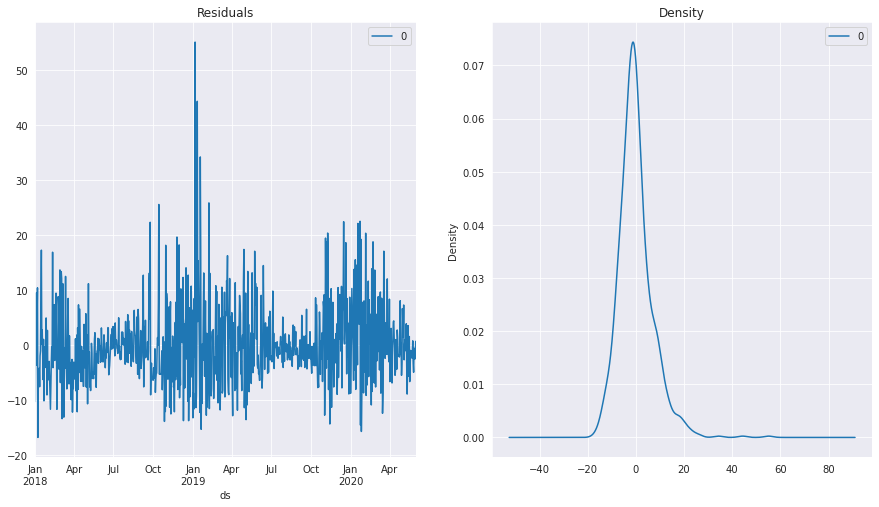

In [6]:
# Plot residual errors
residuals = pd.DataFrame(model_fitted.resid)
fig, ax = plt.subplots(1,2, figsize = (15, 8))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

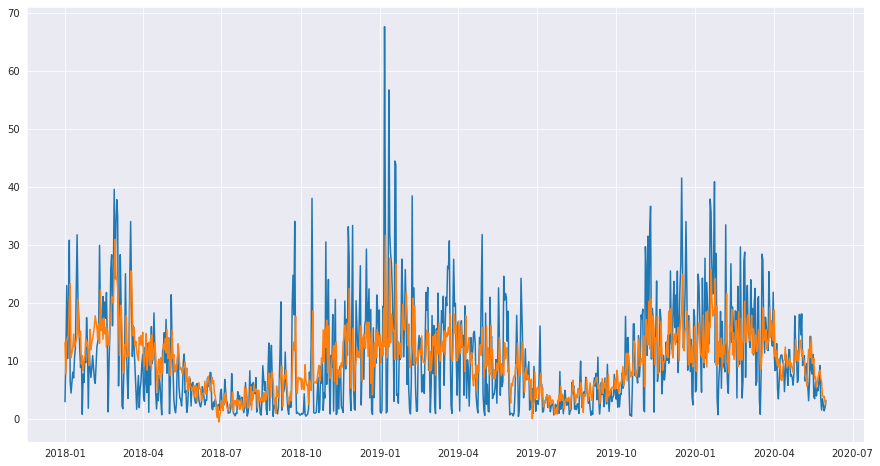

In [7]:
fig = plt.figure(figsize = (15, 8))
plt.plot(train['y'], label = "obs")
plt.plot(model_fitted.fittedvalues, label = "predicted")

# SARIMA Model

In [8]:
sarimax = sm.tsa.statespace.SARIMAX(train.y,order=([1,0,1]),trend='c', seasonal_order=(1,0,1,12),
                                 enforce_stationarity=False, enforce_invertibility=False ).fit()
sarimax.summary()


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.06320D+00    |proj g|=  4.69701D+01

At iterate    5    f=  3.38615D+00    |proj g|=  1.08806D-02


 This problem is unconstrained.



At iterate   10    f=  3.38553D+00    |proj g|=  1.37968D-02

At iterate   15    f=  3.38486D+00    |proj g|=  4.06449D-03

At iterate   20    f=  3.38395D+00    |proj g|=  9.31463D-03

At iterate   25    f=  3.38226D+00    |proj g|=  5.37019D-03

At iterate   30    f=  3.38218D+00    |proj g|=  3.32759D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     36      1     0     0   2.562D-05   3.382D+00
  F =   3.3821803597322293     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  882
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood               -2983.083
Date:                            Sun, 15 May 2022   AIC                           5978.166
Time:                                    12:45:53   BIC                           6006.763
Sample:                                01-01-2018   HQIC                          5989.109
                                     - 05-31-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.2133      0.762      2.904      0.004       0.720       3.707
ar.L1          0.5406      0.048     11.341      0.000       0.447       0.634
ma.L1         -0.0855      0.055     -1.554      0.120      -0.193       0.022
ar.S.L12       0.5119      0.143      3.577      0.000       0.231       0.792
ma.S.L12      -0.4086      0.147     -2.788      0.005      -0.696      -0.121
sigma2        56.4325      1.732     32.581      0.000      53.038      59.827
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              1507.10
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               1.45   Skew:                             1.51
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

SARIMA model MSE:26.00627908821811


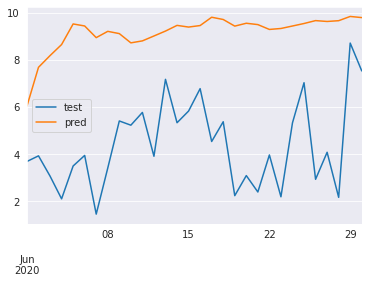

In [9]:
pred = sarimax.predict(tr_end,te_end)[1:]
print('SARIMA model MSE:{}'.format(mean_squared_error(test.y,pred)))

pd.DataFrame({'test':test.y.values.flatten(),'pred':pred}).plot();plt.show()



## SARIMAX Model with exogenous air temp data

In [ ]:
sarimax = sm.tsa.statespace.SARIMAX(train.y,order=(1,0,1),trend='c', seasonal_order=(1,0,1,12),
                                 enforce_stationarity=False, enforce_invertibility=False, exog=train.air_temperature).fit()
sarimax.summary()



In [ ]:
pred = sarimax.predict(tr_end,te_end,exog=test.air_temperature)[1:]
print('SARIMA model MSE:{}'.format(mean_squared_error(test.y,pred)))

pd.DataFrame({'test':test.y.values.flatten(),'pred':pred}).plot();plt.show()



In [ ]:
sarimax.plot_diagnostics(figsize=(15, 12))

# SARIMAX-model with all Exogenous data

In [ ]:
sarimax = sm.tsa.statespace.SARIMAX(train.y,order=(1,1,1),trend='c',seasonal_order=(1,1,1,12),
                                 enforce_stationarity=False, enforce_invertibility=False,exog=train[['air_temperature', 'wind_direction', 'wind_speed', 'msl_pressure', 'rltv_hum', 'stn_pres']]).fit()
sarimax.summary()


In [ ]:


pred = sarimax.predict(tr_end,te_end,exog=test[['air_temperature', 'wind_direction', 'wind_speed', 'msl_pressure', 'rltv_hum', 'stn_pres']])[1:]
print('SARIMA model MSE:{}'.format(mean_squared_error(test.y,pred)))

pd.DataFrame({'test':test.y.values.flatten(),'pred':pred}).plot();plt.show()



In [ ]:
## Removing non significant terms
sarimax = sm.tsa.statespace.SARIMAX(train.y,order=(1,1,1),trend='c',seasonal_order=(1,1,1,12),
                                 enforce_stationarity=False, enforce_invertibility=False,exog=train[['air_temperature', 'wind_direction', 'wind_speed', 'msl_pressure', 'stn_pres']]).fit()
sarimax.summary()


In [ ]:

pred = sarimax.predict(tr_end,te_end,exog=test[['air_temperature', 'wind_direction', 'wind_speed', 'msl_pressure', 'stn_pres']])[1:]
print('SARIMA model MSE:{}'.format(mean_squared_error(test.y,pred)))

pd.DataFrame({'test':test.y.values.flatten(),'pred':pred}).plot();plt.show()


In [ ]:
## Removing non significant terms
sarimax = sm.tsa.statespace.SARIMAX(train.y,order=(1,1,1),trend='c',seasonal_order=(1,1,1,12),
                                 enforce_stationarity=False, enforce_invertibility=False,exog=train[['air_temperature', 'wind_direction', 'wind_speed']]).fit()
sarimax.summary()


In [ ]:
pred = sarimax.predict(tr_end,te_end,exog=test[['air_temperature', 'wind_direction', 'wind_speed']])[1:]
print('SARIMA model MSE:{}'.format(mean_squared_error(test.y,pred)))

pd.DataFrame({'test':test.y.values.flatten(),'pred':pred}).plot();plt.show()


In [ ]:
## Removing ma term
sarimax = sm.tsa.statespace.SARIMAX(train.y,order=(1,1,0),trend='c',seasonal_order=(1,1,0,12),
                                 enforce_stationarity=False, enforce_invertibility=False,exog=train[['air_temperature', 'wind_direction', 'wind_speed']]).fit()
sarimax.summary()

In [ ]:
pred = sarimax.predict(tr_end,te_end,exog=test[['air_temperature', 'wind_direction', 'wind_speed']])[1:]
print('SARIMA model MSE:{}'.format(mean_squared_error(test.y,pred)))

pd.DataFrame({'test':test.y.values.flatten(),'pred':pred}).plot();plt.show()

In [ ]:
## Removing ma term
sarimax = sm.tsa.statespace.SARIMAX(train.y,order=(1,1,0),trend='c',seasonal_order=(1,1,0,12),
                                 enforce_stationarity=False, enforce_invertibility=False,exog=train[[ 'wind_speed']]).fit()
sarimax.summary()

In [ ]:
pred = sarimax.predict(tr_end,te_end,exog=test[['wind_speed']])[1:]
print('SARIMA model MSE:{}'.format(mean_squared_error(test.y,pred)))

pd.DataFrame({'test':test.y.values.flatten(),'pred':pred}).plot();plt.show()

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
res = seasonal_decompose(train.y, model = "additive")

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
res.trend.plot(ax=ax1,ylabel = "trend")
res.resid.plot(ax=ax2,ylabel = "residual")
res.seasonal.plot(ax=ax3,ylabel = "seasonality")
plt.show()

In [ ]:

fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(train.y.diff().dropna(), lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(train.y.diff().dropna(), lags=50, ax=ax[1])
plt.show()



# Final Predictions

In [10]:


mod = sm.tsa.statespace.SARIMAX(train.y, order=(5,1,3),trend='c', seasonal_order=(5,1,3,12),
                                 enforce_stationarity=False, enforce_invertibility=False)
res = mod.fit()
res.summary()



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.23244D+00    |proj g|=  5.92177D-02


 This problem is unconstrained.



At iterate    5    f=  3.20780D+00    |proj g|=  4.06742D-02

At iterate   10    f=  3.16501D+00    |proj g|=  5.27358D-02

At iterate   15    f=  3.13824D+00    |proj g|=  5.06032D-02

At iterate   20    f=  3.11812D+00    |proj g|=  7.77284D-02

At iterate   25    f=  3.11429D+00    |proj g|=  8.64250D-02

At iterate   30    f=  3.11387D+00    |proj g|=  1.80983D-02

At iterate   35    f=  3.11369D+00    |proj g|=  6.26007D-03

At iterate   40    f=  3.11364D+00    |proj g|=  8.91493D-03

At iterate   45    f=  3.11354D+00    |proj g|=  7.54195D-03

At iterate   50    f=  3.11352D+00    |proj g|=  1.31239D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  882
Model:             SARIMAX(5, 1, 3)x(5, 1, 3, 12)   Log Likelihood               -2746.120
Date:                            Sun, 15 May 2022   AIC                           5528.241
Time:                                    12:47:05   BIC                           5612.654
Sample:                                01-01-2018   HQIC                          5560.661
                                     - 05-31-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0019      0.007      0.286      0.775      -0.011       0.015
ar.L1         -0.6869      0.132     -5.223      0.000      -0.945      -0.429
ar.L2         -0.4649      0.102     -4.567      0.000      -0.664      -0.265
ar.L3          0.1218      0.060      2.026      0.043       0.004       0.240
ar.L4         -0.1047      0.052     -2.021      0.043      -0.206      -0.003
ar.L5          0.0807      0.042      1.909      0.056      -0.002       0.164
ma.L1          0.1047      0.133      0.789      0.430      -0.155       0.365
ma.L2         -0.2509      0.099     -2.546      0.011      -0.444      -0.058
ma.L3         -0.6532      0.109     -6.016      0.000      -0.866      -0.440
ar.S.L12      -0.8450      0.213     -3.969      0.000      -1.262      -0.428
ar.S.L24      -0.3775      0.230     -1.641      0.101      -0.828       0.073
ar.S.L36       0.0100      0.047      0.213      0.831      -0.082       0.102
ar.S.L48      -0.0255      0.040     -0.629      0.529      -0.105       0.054
ar.S.L60       0.0010      0.031      0.032      0.974      -0.059       0.061
ma.S.L12      -0.1203      0.228     -0.527      0.598      -0.568       0.327
ma.S.L24      -0.4870      0.167     -2.923      0.003      -0.814      -0.160
ma.S.L36      -0.3808      0.234     -1.628      0.104      -0.839       0.078
sigma2        52.3623      4.201     12.463      0.000      44.128      60.597
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1316.13
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               1.36   Skew:                             1.19
Prob(H) (two-sided):                  0.01   Kurtosis:                         8.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [11]:


prediction1 = res.get_forecast(steps=214)



In [12]:


prediction1.predicted_mean.tail()



2020-12-27    6.610803
2020-12-28    5.800609
2020-12-29    6.136827
2020-12-30    5.242312
2020-12-31    6.271600
Freq: D, Name: predicted_mean, dtype: float64

In [13]:


pred_ci1 = prediction1.conf_int()



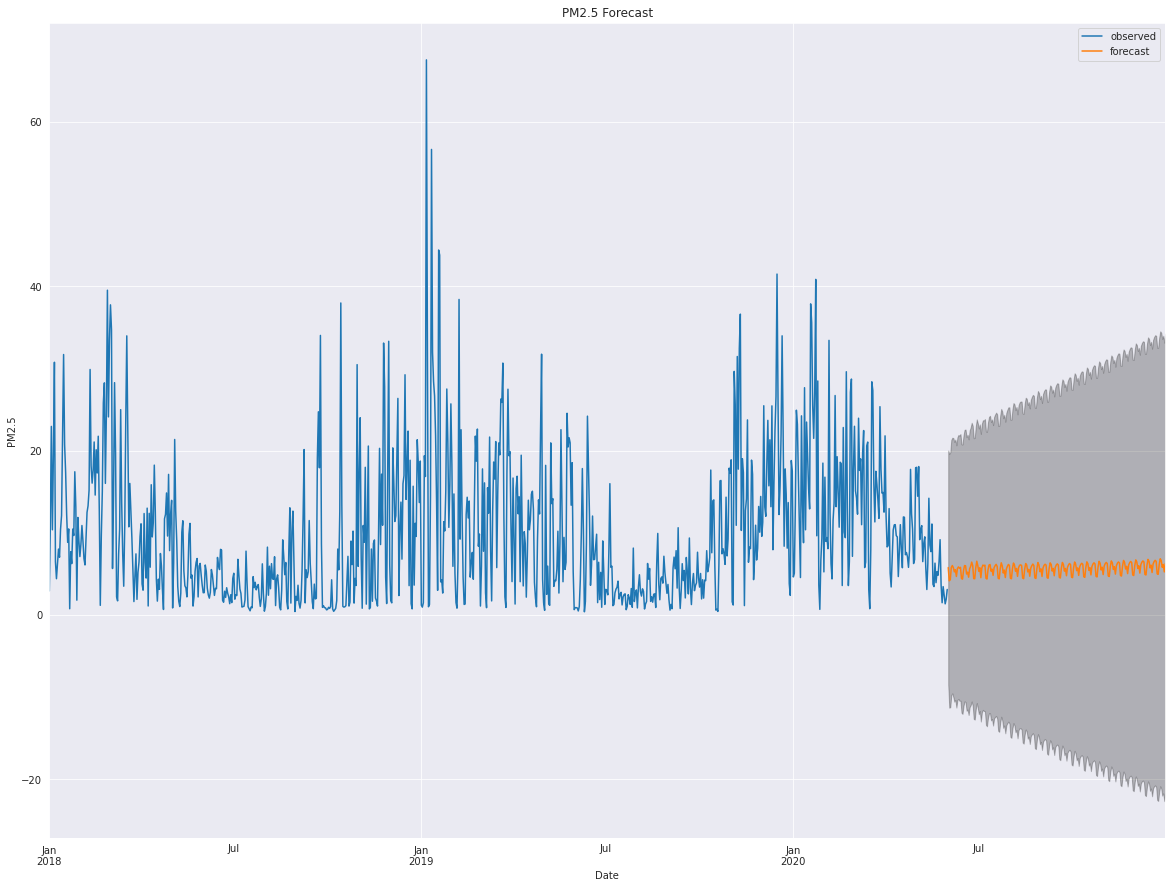

In [14]:
ax = train.y.plot(label='observed', figsize=(20, 15))
prediction1.predicted_mean.plot(ax=ax, label='forecast')
ax.fill_between(pred_ci1.index,
                pred_ci1.iloc[:, 0],
                pred_ci1.iloc[:, 1], color='k', alpha=.25)
ax.set_title('PM2.5 Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('PM2.5')

plt.legend()
plt.show()

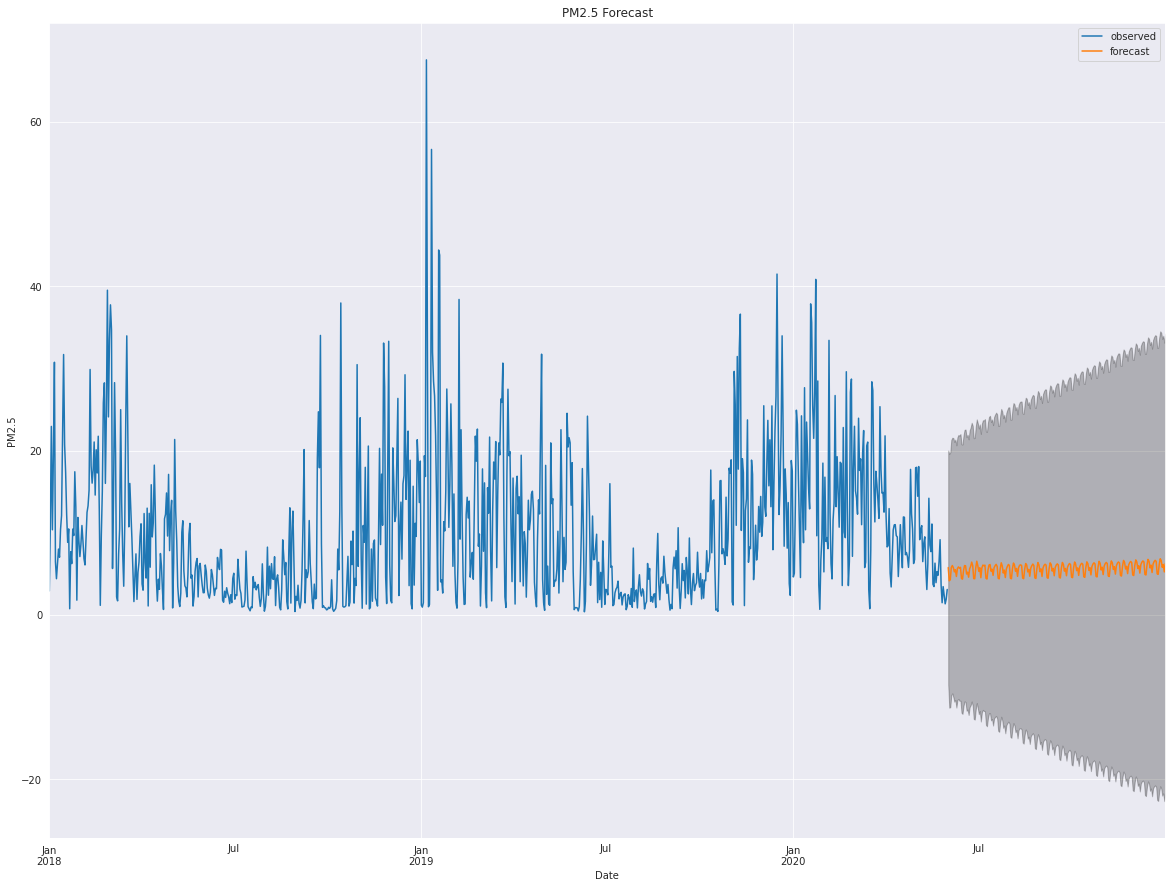

In [15]:
ax = train.y.plot(label='observed', figsize=(20, 15))
prediction1.predicted_mean.plot(ax=ax, label='forecast')
ax.fill_between(pred_ci1.index,
                pred_ci1.iloc[:, 0],
                pred_ci1.iloc[:, 1], color='k', alpha=.25)
ax.set_title('PM2.5 Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('PM2.5')

plt.legend()
plt.show()

# SARIMAX-prediction with air temp as exog

In [31]:



mod = sm.tsa.statespace.SARIMAX(train.y,order=(5,1,3),trend='c', seasonal_order=(5,1,3,12),
                                 enforce_stationarity=False, enforce_invertibility=False,exog=train.air_temperature.values)
res = mod.fit()
res.summary()



 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.21760D+00    |proj g|=  6.26611D-01

At iterate    5    f=  3.21756D+00    |proj g|=  1.12659D+00

At iterate   10    f=  3.21389D+00    |proj g|=  1.41766D+01

At iterate   15    f=  3.20351D+00    |proj g|=  8.24543D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     15     23      1     0     0   8.245D-01   3.204D+00
  F =   3.2035050361366846     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  882
Model:             SARIMAX(5, 1, 3)x(5, 1, 3, 12)   Log Likelihood               -2825.491
Date:                            Sun, 15 May 2022   AIC                           5690.983
Time:                                    12:52:35   BIC                           5784.775
Sample:                                01-01-2018   HQIC                          5727.005
                                     - 05-31-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0128      0.133     -0.096      0.923      -0.274       0.248
drift       1.627e-06      0.000      0.006      0.995      -0.000       0.000
x1            -0.7488      0.288     -2.601      0.009      -1.313      -0.184
ar.L1         -0.5481      0.449     -1.220      0.223      -1.429       0.333
ar.L2         -0.3385      0.359     -0.942      0.346      -1.043       0.366
ar.L3         -0.1035      0.130     -0.798      0.425      -0.358       0.151
ar.L4         -0.1532      0.165     -0.929      0.353      -0.476       0.170
ar.L5          0.0542      0.094      0.576      0.565      -0.130       0.239
ma.L1         -0.0420      0.456     -0.092      0.927      -0.937       0.853
ma.L2         -0.3644      0.348     -1.046      0.296      -1.047       0.319
ma.L3         -0.4326      0.400     -1.080      0.280      -1.217       0.352
ar.S.L12      -0.7641      0.533     -1.433      0.152      -1.809       0.281
ar.S.L24      -0.5540      0.445     -1.245      0.213      -1.426       0.318
ar.S.L36      -0.3173      0.189     -1.675      0.094      -0.689       0.054
ar.S.L48      -0.2302      0.151     -1.528      0.127      -0.526       0.065
ar.S.L60      -0.0943      0.093     -1.008      0.313      -0.278       0.089
ma.S.L12      -0.1260      0.530     -0.238      0.812      -1.165       0.913
ma.S.L24      -0.1588      0.379     -0.418      0.676      -0.902       0.585
ma.S.L36      -0.1613      0.309     -0.522      0.602      -0.767       0.444
sigma2       104.8858      6.333     16.563      0.000      92.474     117.298
===================================================================================
Ljung-Box (L1) (Q):                   0.73   Jarque-Bera (JB):               965.19
Prob(Q):                              0.39   Prob(JB):                         0.00
Heteroskedasticity (H):               1.43   Skew:                             0.99
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:

prediction2 = res.get_forecast(steps=214, exog=exog.air_temperature)

In [33]:


prediction2.predicted_mean.head()



2020-06-01    3.555884
2020-06-02    3.952776
2020-06-03    2.956874
2020-06-04    2.805435
2020-06-05    4.508695
Freq: D, Name: predicted_mean, dtype: float64

In [34]:


pred_ci2 = prediction2.conf_int()



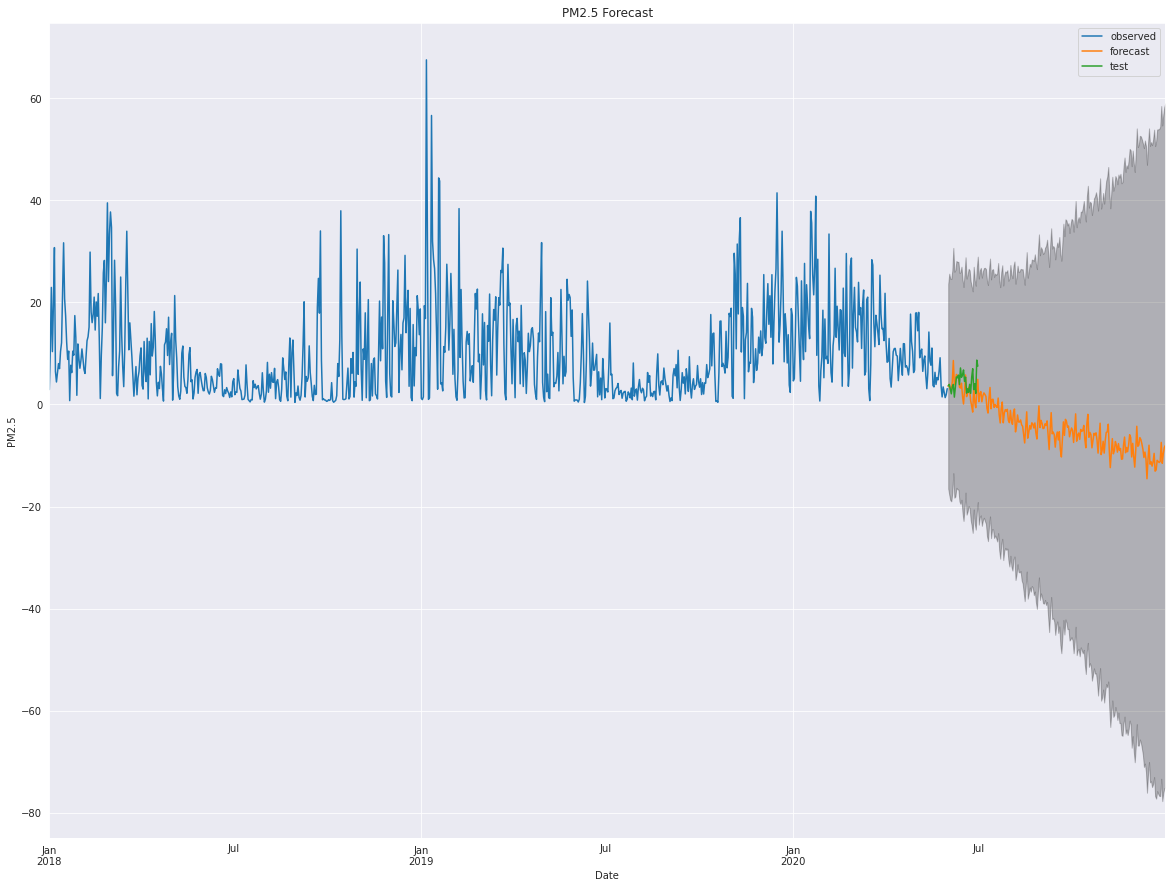

In [35]:

ax = train.y.plot(label='observed', figsize=(20, 15))
prediction2.predicted_mean.plot(ax=ax, label='forecast')
test.y.plot(ax=ax, label = 'test')
ax.fill_between(pred_ci2.index,
                pred_ci2.iloc[:, 0],
                pred_ci2.iloc[:, 1], color='k', alpha=.25)
ax.set_title('PM2.5 Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('PM2.5')

plt.legend()
plt.show()

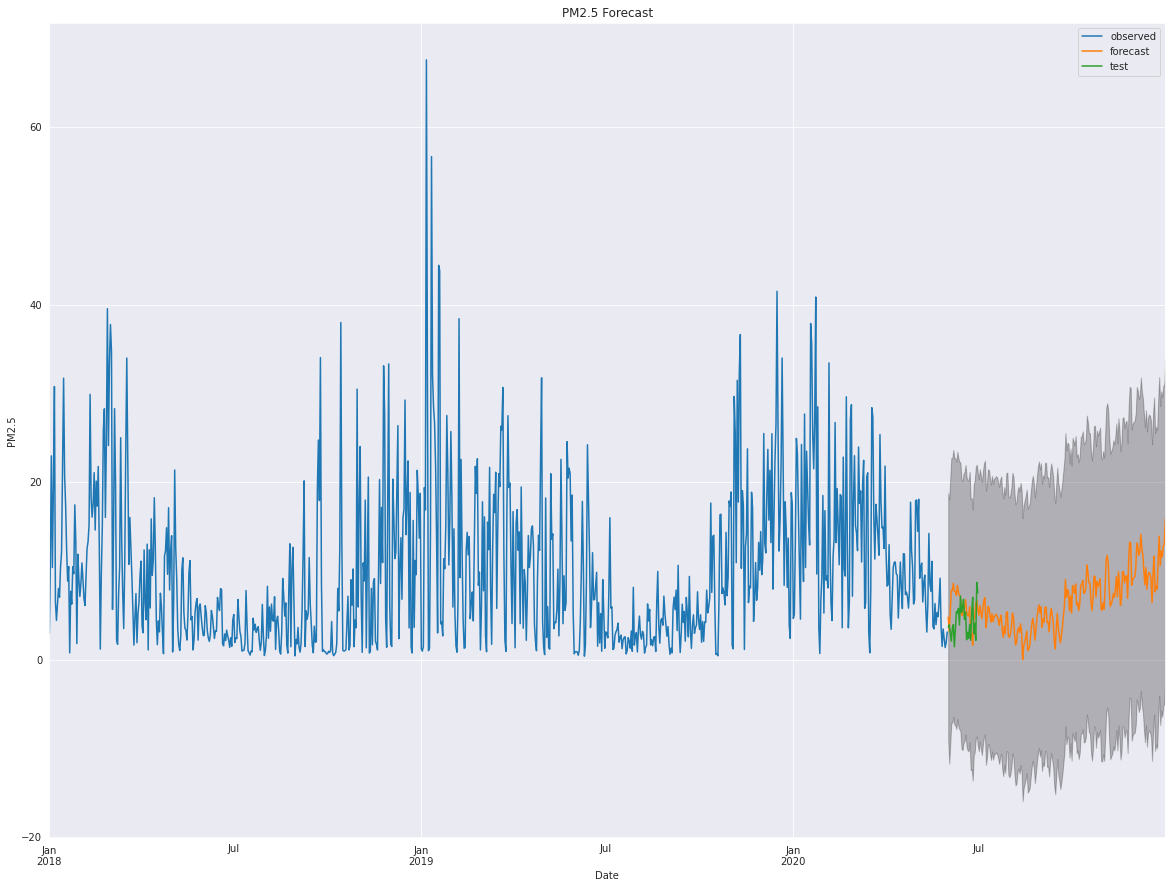

In [20]:


ax = train.y.plot(label='observed', figsize=(20, 15))
prediction2.predicted_mean.plot(ax=ax, label='forecast')
test.y.plot(ax=ax, label = 'test')
ax.fill_between(pred_ci2.index,
                pred_ci2.iloc[:, 0],
                pred_ci2.iloc[:, 1], color='k', alpha=.25)
ax.set_title('PM2.5 Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('PM2.5')

plt.legend()
plt.show()



# SARIMAX-prediction with all exogenous variable

In [ ]:

mod = sm.tsa.statespace.SARIMAX(train.y,order=(5,1,3),trend='c', seasonal_order=(5,1,3,12),
                                 enforce_stationarity=False, enforce_invertibility=False,exog=train[['air_temperature', 'wind_speed']])
res = mod.fit()
res.summary()


In [ ]:
prediction3 = res.get_forecast(steps=214, exog=exog[['air_temperature', 'wind_speed']].values)
pred_ci3 = prediction3.conf_int()
prediction3.predicted_mean.tail()

In [ ]:


ax = train.y.plot(label='observed', figsize=(20, 15))
prediction3.predicted_mean.plot(ax=ax, label='forecast')
test.y.plot(ax=ax, label = 'test')
ax.fill_between(pred_ci3.index,
                pred_ci3.iloc[:, 0],
                pred_ci3.iloc[:, 1], color='k', alpha=.25)
ax.set_title('PM2.5 Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('PM2.5')

plt.legend()
plt.show()



In [ ]:


ax = train.y.plot(label='observed', figsize=(20, 15))
prediction1.predicted_mean.plot(ax=ax, label='PM2.5 only')
prediction2.predicted_mean.plot(ax=ax, label='PM2.5 with air temperature exogenous variable')
prediction3.predicted_mean.plot(ax=ax, label='PM2.5 with air temperature, wind direction, and wind speed as exogogenous variables')

ax.fill_between(pred_ci1.index,
                pred_ci1.iloc[:, 0],
                pred_ci1.iloc[:, 1], color='k', alpha=0.1)

ax.fill_between(pred_ci2.index,
                pred_ci2.iloc[:, 0],
                pred_ci2.iloc[:, 1], color='k', alpha=0.05)

ax.fill_between(pred_ci3.index,
                pred_ci3.iloc[:, 0],
                pred_ci3.iloc[:, 1], color='k', alpha=0.2)


ax.set_title('PM2.5 Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('PM2.5')

plt.legend()
plt.show()



## Testing DON'T RUN

In [ ]:

mod = sm.tsa.statespace.SARIMAX(train.y,order=(5,1,3),trend='c', seasonal_order=(5,1,3,36),
                                 enforce_stationarity=False, enforce_invertibility=False,exog=train[['air_temperature', 'wind_speed']])
res = mod.fit()
res.summary()

In [ ]:
prediction3 = res.get_forecast(steps=214, exog=exog[['air_temperature', 'wind_speed']].values)
pred_ci3 = prediction3.conf_int()
prediction3.predicted_mean.tail()

In [ ]:
ax = train.y.plot(label='observed', figsize=(20, 15))
prediction3.predicted_mean.plot(ax=ax, label='forecast')
test.y.plot(ax=ax, label = 'test')
ax.fill_between(pred_ci3.index,
                pred_ci3.iloc[:, 0],
                pred_ci3.iloc[:, 1], color='k', alpha=.25)
ax.set_title('PM2.5 Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('PM2.5')

plt.legend()
plt.show()



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math
from scipy.stats import variation
from pylab import rcParams
import statsmodels.api as sm
import os
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
%matplotlib inline
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

print(os.getcwd())

#df = pd.read_csv("/content/df_analysis.csv")
df = pd.read_csv("../data/cleanData/df_analysis.csv")

In [ ]:
df_sd = df.copy()
df_sd['ds'] = pd.to_datetime(df_sd['ds'])
df_sd = df_sd.set_index('ds')
df_sd = df_sd.resample('D').mean()
df_sd = df_sd.fillna(0)

In [ ]:
df_dict = {'mean': 'df_mean', 'sum': 'df_sum'}
for i in df_dict:
    print(i)
    
df_dict.keys()

In [ ]:
import pandas as pd
from functools import reduce
df = pd.DataFrame({'Date': [1,2,3,4], 'Value': [2,3,3,4]})
df_dict = {'df_1':df, 'df_2': df, 'df_3': df}
dfList
df_dict.keys()
#reduce(lambda df_dict.keys(): pd.merge(df_dict.keys(), on = 'Date'), df_dict.values())

In [ ]:
df2 = df.copy()
df2['ds'] = pd.to_datetime(df2['ds'])
df2 = df2.set_index('ds')
df2 = df2.resample('D').max()
df2 = df2.fillna(0)


In [ ]:
fig = plt.figure(figsize = (15,8))
plt.plot(df_sd.y.rolling(7, axis = 0).mean())

In [ ]:
fig = plt.figure(figsize = (15,8))
plt.plot(df_sd.y)

In [ ]:
fig = plt.figure(figsize = (15,8))
plt.plot(df2[df2.y < 150].y)